# Predicting the Outcomes of LCS Matches Using Neural Networks

In the following notebook, we will build a neural network to make predictions on the outcomes of LCS matches. We will primarily use the Keras API from TensorFlow. First, let's import the packages and modules we need.

In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from mpl_toolkits.mplot3d import Axes3D 

Next, let's download the data we will be using. Tim Sevenhuysen at OraclesElixir.com has nicely aggregated LCS match data from the past two years of competitive play. For more information, refer to https://oracleselixir.com/matchdata.  

In [118]:
spring_18 = pd.read_excel("./Downloads/2018_spring.xlsx")
summer_18 = pd.read_excel("./Downloads/2018_summer.xlsx")
spring_19 = pd.read_excel("./Downloads/2019_spring.xlsx")
summer_19 = pd.read_excel("./Downloads/2019_summer.xlsx")

Let's combine the data into one dataframe and have a look at the features.

In [119]:
frames = [spring_18, summer_18, spring_19, summer_19]
df = pd.concat(frames)
df.head(10)

,gameid,url,league,split,date,week,game,patchno,playerid,side,...,gdat15,xpat10,oppxpat10,xpdat10,csat10,oppcsat10,csdat10,csat15,oppcsat15,csdat15
0,550246,https://matchhistory.na.leagueoflegends.com/en...,LCK,2018-1,43116.1,1.1,1,8.01,1,Blue,...,1.0,4837.0,4316.0,521.0,88.0,80.0,8.0,130.0,137.0,-7.0
1,550246,https://matchhistory.na.leagueoflegends.com/en...,LCK,2018-1,43116.1,1.1,1,8.01,2,Blue,...,86.0,3464.0,2921.0,543.0,51.0,47.0,4.0,96.0,88.0,8.0
2,550246,https://matchhistory.na.leagueoflegends.com/en...,LCK,2018-1,43116.1,1.1,1,8.01,3,Blue,...,-88.0,4468.0,4072.0,396.0,86.0,77.0,9.0,138.0,146.0,-8.0
3,550246,https://matchhistory.na.leagueoflegends.com/en...,LCK,2018-1,43116.1,1.1,1,8.01,4,Blue,...,70.0,3476.0,3368.0,108.0,101.0,94.0,7.0,150.0,148.0,2.0
4,550246,https://matchhistory.na.leagueoflegends.com/en...,LCK,2018-1,43116.1,1.1,1,8.01,5,Blue,...,-124.0,2858.0,3025.0,-167.0,28.0,33.0,-5.0,46.0,53.0,-7.0
5,550246,https://matchhistory.na.leagueoflegends.com/en...,LCK,2018-1,43116.1,1.1,1,8.01,6,Red,...,-1.0,4316.0,4837.0,-521.0,80.0,88.0,-8.0,137.0,130.0,7.0
6,550246,https://matchhistory.na.leagueoflegends.com/en...,LCK,2018-1,43116.1,1.1,1,8.01,7,Red,...,-86.0,2921.0,3464.0,-543.0,47.0,51.0,-4.0,88.0,96.0,-8.0
7,550246,https://matchhistory.na.leagueoflegends.com/en...,LCK,2018-1,43116.1,1.1,1,8.01,8,Red,...,88.0,4072.0,4468.0,-396.0,77.0,86.0,-9.0,146.0,138.0,8.0
8,550246,https://matchhistory.na.leagueoflegends.com/en...,LCK,2018-1,43116.1,1.1,1,8.01,9,Red,...,-70.0,3368.0,3476.0,-108.0,94.0,101.0,-7.0,148.0,150.0,-2.0
9,550246,https://matchhistory.na.leagueoflegends.com/en...,LCK,2018-1,43116.1,1.1,1,8.01,10,Red,...,124.0,3025.0,2858.0,167.0,33.0,28.0,5.0,53.0,46.0,7.0


One of the predictors we're interested in looking at is champion picks. Since this data is categorical, let's use one-hot encoding to transform it into a usable form.

In [120]:
champs = df['champion'].copy().apply(lambda x : x.replace(" ", "").replace("'", "").lower())
champs_dummies = pd.get_dummies(champs).drop("", axis = 1)
champs_dummies.head(10)

,aatrox,ahri,akali,alistar,amumu,anivia,annie,ashe,aurelionsol,azir,...,xinzhao,yasuo,yorick,yuumi,zac,zed,ziggs,zilean,zoe,zyra
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


It doesn't look like much, but this is what we were looking for. <code>0</code> indicates that a champion was not picked, while <code>1</code> marks the opposite. Let's also do one-hot encoding for side selection.

In [121]:
side = df['side'].copy()
side_dummies = pd.get_dummies(side)

There are a lot of features to choose from in addition to champions and sides. However, not all of them are useful. We're interested in making outcome predictions based on the early game, so we can throw out late game features such as Baron takes. Features such as date and split are not relevant, so let's throw those out too. We want to avoid overfitting by selecting too many features, so let's choose those that we think are strongly correlated with a team's victory and put them in a feature matrix.

In [122]:
X = df[['gameid', 'team', 'position', 'gdat15', 'xpdat10', 'csdat10', 'fb', 'ft', 'fd', 'result']].copy()
X = pd.concat([X, champs_dummies, side_dummies], axis = 1)
X.head(10)

,gameid,team,position,gdat15,xpdat10,csdat10,fb,ft,fd,result,...,yorick,yuumi,zac,zed,ziggs,zilean,zoe,zyra,Blue,Red
0,550246,Kingzone DragonX,Top,1.0,521.0,8.0,0,0.0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,550246,Kingzone DragonX,Jungle,86.0,543.0,4.0,0,0.0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,550246,Kingzone DragonX,Middle,-88.0,396.0,9.0,1,0.0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,550246,Kingzone DragonX,ADC,70.0,108.0,7.0,0,0.0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,550246,Kingzone DragonX,Support,-124.0,-167.0,-5.0,0,0.0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,550246,KSV Esports,Top,-1.0,-521.0,-8.0,0,1.0,0,1,...,0,0,0,0,0,0,0,0,0,1
6,550246,KSV Esports,Jungle,-86.0,-543.0,-4.0,0,1.0,1,1,...,0,0,0,0,0,0,0,0,0,1
7,550246,KSV Esports,Middle,88.0,-396.0,-9.0,0,1.0,0,1,...,0,0,0,0,0,0,0,0,0,1
8,550246,KSV Esports,ADC,-70.0,-108.0,-7.0,0,1.0,0,1,...,0,0,0,0,0,0,0,0,0,1
9,550246,KSV Esports,Support,124.0,167.0,5.0,0,1.0,0,1,...,0,0,0,0,0,0,0,0,0,1


The data looks cleaner already. As it stands, there are five entries per team per game played, corresponding to each team's five players. We're more interested in team values, so let's combine player values. 

In [123]:
X = X[X['position'] != 'Team'].drop('position', axis = 1)
X = X.dropna()
X.iloc[:, 2:] = X.iloc[:, 2:].astype('float64')
X = X.groupby(['gameid', 'team']).sum()
X[['ft', 'result', 'Blue', 'Red']] = X[['ft', 'result', 'Blue', 'Red']].apply(lambda x : [1. if t > 0 else 0. for t in x])
y = X['result']
X = X.drop('result', axis = 1)
X.head(10)

gdat15  xpdat10  csdat10   fb   ft   fd  aatrox  \
gameid team                                                                  
210112 Fenerbahce Esports  -691.0     51.0     10.0  0.0  0.0  1.0     0.0   
       Team AURORA          691.0    -51.0    -10.0  1.0  1.0  0.0     0.0   
210117 Fenerbahce Esports -5544.0  -1118.0    -29.0  1.0  0.0  0.0     0.0   
       Team AURORA         5544.0   1118.0     29.0  0.0  1.0  1.0     0.0   
210118 Fenerbahce Esports  4431.0   1947.0      9.0  1.0  0.0  0.0     0.0   
       Team AURORA        -4431.0  -1947.0     -9.0  0.0  1.0  1.0     0.0   
210119 Fenerbahce Esports -1701.0  -1992.0    -47.0  0.0  0.0  0.0     0.0   
       Team AURORA         1701.0   1992.0     47.0  1.0  1.0  1.0     0.0   
210133 Dark Passage        3212.0    138.0      3.0  0.0  1.0  1.0     0.0   
       YouthCREW          -3212.0   -138.0     -3.0  1.0  0.0  0.0     0.0   

                           ahri  akali  alistar  ...  yorick  yuumi  zac  zed  \
gameid team                                      ...                            
210112 Fenerbahce Esports   0.0    0.0      0.0  ...     0.0    0.0  0.0  0.0   
       Team AURORA          0.0    0.0      0.0  ...     0.0    0.0  0.0  0.0   
210117 Fenerbahce Esports   0.0    0.0      0.0  ...     0.0    0.0  0.0  0.0   
       Team AURORA          0.0    0.0      0.0  ...     0.0    0.0  0.0  0.0   
210118 Fenerbahce Esports   0.0    0.0      1.0  ...     0.0    0.0  0.0  0.0   
       Team AURORA          0.0    0.0      0.0  ...     0.0    0.0  0.0  0.0   
210119 Fenerbahce Esports   0.0    0.0      0.0  ...     0.0    0.0  0.0  0.0   
       Team AURORA          0.0    0.0      0.0  ...     0.0    0.0  0.0  0.0   
210133 Dark Passage         0.0    0.0      0.0  ...     0.0    0.0  0.0  0.0   
       YouthCREW            0.0    0.0      0.0  ...     0.0    0.0  0.0  0.0   

                           ziggs  zilean  zoe  zyra  Blue  Red  
gameid team                                                     
210112 Fenerbahce Esports    0.0     0.0  0.0   0.0   0.0  1.0  
       Team AURORA           0.0     0.0  0.0   0.0   1.0  0.0  
210117 Fenerbahce Esports    0.0     0.0  1.0   0.0   0.0  1.0  
       Team AURORA           0.0     0.0  0.0   0.0   1.0  0.0  
210118 Fenerbahce Esports    0.0     0.0  0.0   0.0   1.0  0.0  
       Team AURORA           0.0     0.0  0.0   0.0   0.0  1.0  
210119 Fenerbahce Esports    0.0     0.0  0.0   0.0   0.0  1.0  
       Team AURORA           0.0     0.0  0.0   0.0   1.0  0.0  
210133 Dark Passage          0.0     0.0  0.0   0.0   1.0  0.0  
       YouthCREW             0.0     0.0  0.0   0.0   0.0  1.0  

[10 rows x 151 columns]

As expected, most of the stats from opposing teams are mirrored. For example, if a team has a positive gold difference at 15 minutes, then its opponent must have an equally negative gold difference. We can avoid this redundancy and improve training speed by keeping only one entry per game played. This means we have to modify our categorical features slightly. As before, positive statistics by the home team are denoted by <code>1</code>; negative statistics by the enemy team are denoted by <code>-1</code>.

In [124]:
left = X.iloc[:, :3].reset_index()
right = X.iloc[:, 3:].reset_index()
left = left.groupby(["gameid"]).apply(lambda g : g.iloc[0, :]).drop(["gameid", "team"], axis = 1)
right = right.groupby(["gameid"]).apply(lambda g : g.iloc[0, 1:] - g.iloc[1, 1:])
X = pd.concat([left, right], axis = 1)
y = y.reset_index()
y = y.groupby(["gameid"]).apply(lambda g : g.iloc[0, :])["result"]
X.head()

,gdat15,xpdat10,csdat10,fb,ft,fd,aatrox,ahri,akali,alistar,...,yorick,yuumi,zac,zed,ziggs,zilean,zoe,zyra,Blue,Red
gameid,,,,,,,,,,,,,,,,,,,,,
210112,-691.0,51.0,10.0,-1.0,-1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
210117,-5544.0,-1118.0,-29.0,1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,1.0
210118,4431.0,1947.0,9.0,1.0,-1.0,-1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0
210119,-1701.0,-1992.0,-47.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
210133,3212.0,138.0,3.0,-1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0


Let's normalize the data and put it into a feature matrix.

In [125]:
X_ = X.values
y_ = y.values.astype(int)
mu = np.mean(X_[:, :3], axis = 0)
sigma = np.std(X_[:, :3], axis = 0)
X_[:, :3] = (X_[:, :3] - mu) / sigma
print("standard deviation: ", sigma)

standard deviation:  [2589.99757553  985.98264818   26.50661778]


To begin with, let's train a neural network with one layer. Since the result is dichotomous, we'll use the binary cross entropy loss.

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size = 0.2, shuffle = True)
model = keras.Sequential([keras.layers.Dense(20, input_dim = 151, activation = "relu"),
                          keras.layers.Dense(1, activation = "sigmoid")])
model.compile(optimizer = "adam",
              loss = keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy'])
model.fit(X_train, y_train, epochs = 10)

Train on 2748 samples
Epoch 1/10
2748/2748 [==============================] - 0s 145us/sample - loss: 0.6480 - accuracy: 0.6190
Epoch 2/10
2748/2748 [==============================] - 0s 32us/sample - loss: 0.5655 - accuracy: 0.7074
Epoch 3/10
2748/2748 [==============================] - 0s 32us/sample - loss: 0.5362 - accuracy: 0.7267
Epoch 4/10
2748/2748 [==============================] - 0s 32us/sample - loss: 0.5170 - accuracy: 0.7416
Epoch 5/10
2748/2748 [==============================] - 0s 32us/sample - loss: 0.5013 - accuracy: 0.7547
Epoch 6/10
2748/2748 [==============================] - ETA: 0s - loss: 0.4879 - accuracy: 0.76 - 0s 33us/sample - loss: 0.4891 - accuracy: 0.7656
Epoch 7/10
2748/2748 [==============================] - 0s 34us/sample - loss: 0.4780 - accuracy: 0.7715
Epoch 8/10
2748/2748 [==============================] - 0s 37us/sample - loss: 0.4686 - accuracy: 0.7773
Epoch 9/10
2748/2748 [==============================] - 0s 33us/sample - loss: 0.4601 - accurac

Let's evaluate the neural network on the test set. 

In [127]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose = 2)
print("accuracy: ", test_acc)

688/688 - 0s - loss: 0.5121 - accuracy: 0.7326
accuracy:  0.73255813


Not too bad for a first attempt. Let's see what happens if we train the network for more epochs, keeping all other variables constant. 

In [139]:
epochs = (10 * np.linspace(1, 10, 10)).astype(int)
accs = []
losses = []
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size = 0.2, shuffle = True)
for e in epochs:
    model = keras.Sequential([keras.layers.Dense(20, input_dim = 151, activation = "relu"),
                          keras.layers.Dense(1, activation = "sigmoid")])
    model.compile(optimizer = "adam",
                  loss = keras.losses.BinaryCrossentropy(),
                  metrics = ['accuracy'])
    model.fit(X_train, y_train, epochs = e, verbose = 0)
    loss, acc = model.evaluate(X_test, y_test, verbose = 0)
    accs.append(acc)
    losses.append(loss)

Let's plot the results. Hopefully, the test accuracy increases as we increase the training time. 

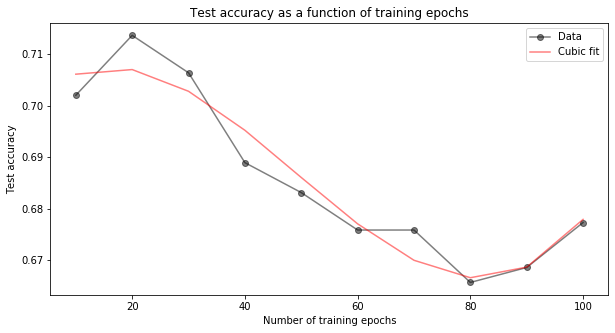

In [140]:
z = np.polyfit(epochs, accs, 3)
p = np.poly1d(z)
fig = plt.figure(figsize = (10, 5))
plt.plot(epochs, accs, '-o', color = 'k', alpha = 0.5, label = 'Data')
plt.plot(epochs, p(epochs), '-', color = 'red', alpha = 0.5, label = 'Cubic fit')
plt.xlabel("Number of training epochs")
plt.ylabel("Test accuracy")
plt.legend()
plt.title("Test accuracy as a function of training epochs")
plt.show()

Not quite what we were hoping for. As we increase the number of epochs, we are likely to overfit the training data. As a result, the model does not generalize well to the test set. Let's keep the number of epochs low and add another layer to the network.

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size = 0.2, shuffle = True)
model = keras.Sequential([keras.layers.Dense(20, input_dim = 151, activation = "relu"),
                          keras.layers.Dense(10, activation = "relu"),
                          keras.layers.Dense(1, activation = "sigmoid")])
model.compile(optimizer = "adam",
              loss = keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy'])
model.fit(X_train, y_train, epochs = 10)

Train on 2748 samples
Epoch 1/10
2748/2748 [==============================] - 0s 156us/sample - loss: 0.6620 - accuracy: 0.5935
Epoch 2/10
2748/2748 [==============================] - 0s 32us/sample - loss: 0.5888 - accuracy: 0.7016
Epoch 3/10
2748/2748 [==============================] - 0s 32us/sample - loss: 0.5485 - accuracy: 0.7253
Epoch 4/10
2748/2748 [==============================] - 0s 35us/sample - loss: 0.5242 - accuracy: 0.7384
Epoch 5/10
2748/2748 [==============================] - 0s 33us/sample - loss: 0.5044 - accuracy: 0.7533
Epoch 6/10
2748/2748 [==============================] - 0s 33us/sample - loss: 0.4874 - accuracy: 0.7675
Epoch 7/10
2748/2748 [==============================] - 0s 35us/sample - loss: 0.4702 - accuracy: 0.7809
Epoch 8/10
2748/2748 [==============================] - 0s 33us/sample - loss: 0.4552 - accuracy: 0.7922
Epoch 9/10
2748/2748 [==============================] - 0s 32us/sample - loss: 0.4409 - accuracy: 0.7999
Epoch 10/10
2748/2748 [=========

In [142]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose = 2)
print("accuracy: ", test_acc)

688/688 - 0s - loss: 0.5448 - accuracy: 0.7282
accuracy:  0.7281977


Unfortunately, we aren't seeing major improvements. Since we're still worried about overfitting, let's add a dropout layer to our network. This allows us to train the model for a bit longer. 

In [143]:
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size = 0.2, shuffle = True)
model = keras.Sequential([keras.layers.Dense(20, input_dim = 151, activation = "relu"),
                          keras.layers.Dropout(0.1),
                          keras.layers.Dense(10, activation = "relu"),
                          keras.layers.Dense(1, activation = "sigmoid")])
model.compile(optimizer = "adam",
              loss = keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy'])
model.fit(X_train, y_train, epochs = 15)

Train on 2748 samples
Epoch 1/15
2748/2748 [==============================] - 0s 173us/sample - loss: 0.6387 - accuracy: 0.6488
Epoch 2/15
2748/2748 [==============================] - 0s 38us/sample - loss: 0.5669 - accuracy: 0.7180
Epoch 3/15
2748/2748 [==============================] - 0s 34us/sample - loss: 0.5402 - accuracy: 0.7384
Epoch 4/15
2748/2748 [==============================] - 0s 33us/sample - loss: 0.5175 - accuracy: 0.7471
Epoch 5/15
2748/2748 [==============================] - 0s 34us/sample - loss: 0.5106 - accuracy: 0.7507
Epoch 6/15
2748/2748 [==============================] - 0s 38us/sample - loss: 0.4907 - accuracy: 0.7642
Epoch 7/15
2748/2748 [==============================] - 0s 37us/sample - loss: 0.4781 - accuracy: 0.7638
Epoch 8/15
2748/2748 [==============================] - 0s 36us/sample - loss: 0.4752 - accuracy: 0.7642
Epoch 9/15
2748/2748 [==============================] - 0s 39us/sample - loss: 0.4580 - accuracy: 0.7780
Epoch 10/15
2748/2748 [=========

In [144]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose = 2)
print("accuracy: ", test_acc)

688/688 - 0s - loss: 0.5509 - accuracy: 0.7369
accuracy:  0.7369186


Our model should be a bit more robust now. We can refine it even more with k-fold cross-validation. Let's use 10 folds for now.

In [145]:
n = 10
kf = KFold(n_splits = n)
accs = []
losses = []
for train_index, test_index in kf.split(X_):
    model = keras.Sequential([keras.layers.Dense(20, input_dim = 151, activation = "relu"),
                          keras.layers.Dropout(0.1),
                          keras.layers.Dense(10, activation = "relu"),
                          keras.layers.Dense(1, activation = "sigmoid")])
    model.compile(optimizer = "adam",
                  loss = keras.losses.BinaryCrossentropy(),
                  metrics = ['accuracy'])
    X_train, X_cv, y_train, y_cv = X_[train_index], X_[test_index], y_[train_index], y_[test_index]
    model.fit(X_train, y_train, epochs = 15, verbose = 0)
    cv_loss, cv_acc = model.evaluate(X_cv,  y_cv, verbose = 0)
    accs.append(cv_acc)
    losses.append(cv_loss)

In [146]:
print("average accuracy: ", np.mean(accs))
print("average loss: ", np.mean(losses))
print("accuracy sigma: ", np.std(accs))
print("loss sigma: ", np.std(losses))

average accuracy:  0.7185648
average loss:  0.5662919706442014
accuracy sigma:  0.021758568
loss sigma:  0.0261420041431866


The average test accuracy for each fold is about the same as it was before, but we should improve our performance if we average the results. Let's see how this approach fares as we vary the size of the first layer.

In [147]:
nodes = (10 * np.linspace(1, 10, 10)).astype(int)
kf = KFold(n_splits = 10)
cat = []
for rep in range(1, 4):
    X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, test_size = 0.2, shuffle = True)
    accs = []
    for n in nodes:
        preds = []
        for train_index, cv_index in kf.split(X_train_):
            X_train, X_cv, y_train, y_cv = X_train_[train_index], X_train_[cv_index], y_train_[train_index], y_train_[cv_index]
            model = keras.Sequential([keras.layers.Dense(n, input_dim = 151, activation = "relu"),
                                  keras.layers.Dropout(0.1),
                                  keras.layers.Dense(10, activation = "relu"),
                                  keras.layers.Dense(1, activation = "sigmoid")])
            model.compile(optimizer = "adam",
                          loss = keras.losses.BinaryCrossentropy(),
                          metrics = ['accuracy'])
            model.fit(X_train, y_train, epochs = 15, verbose = 0)
            pred = model.predict(X_test_)
            preds.append(pred)
        y_pred = np.rint(np.mean(preds, axis = 0).flatten()).astype(int)
        accs.append(accuracy_score(y_test_, y_pred))
    cat.append(accs)

As before, let's visualize the results. The x-axis shows the number of first layer nodes and the y-axis shows the test accuracy. The different colors correspond to different initializations of the training and test sets.

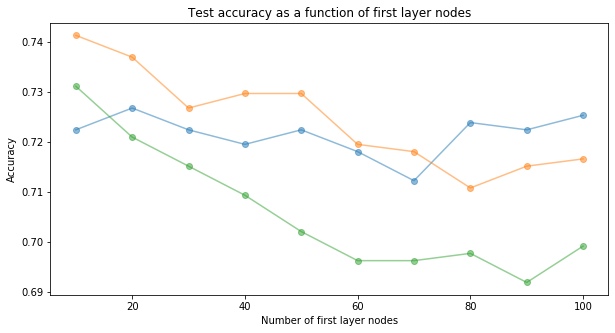

In [148]:
fig = plt.figure(figsize = (10, 5))
for accs in cat:
    plt.plot(nodes, accs, '-o', alpha = 0.5)
plt.xlabel("Number of first layer nodes")
plt.ylabel("Accuracy")
plt.title("Test accuracy as a function of first layer nodes")
plt.show()

It seems like the accuracy drops as we add more nodes. As the model becomes increasingly complicated, it is more likely to overfit the training data. To justify adding complexity, we probably need to expand the data set. For the sake of thoroughness, let's also vary the number of nodes in the second layer.

In [151]:
nodes = (10 * np.linspace(1, 10, 10)).astype(int)
kf = KFold(n_splits = 10)
cat = []
for rep in range(1, 4):
    X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, test_size = 0.2, shuffle = True)
    accs = []
    for n in nodes:
        preds = []
        for train_index, cv_index in kf.split(X_train_):
            X_train, X_cv, y_train, y_cv = X_train_[train_index], X_train_[cv_index], y_train_[train_index], y_train_[cv_index]
            model = keras.Sequential([keras.layers.Dense(20, input_dim = 151, activation = "relu"),
                                  keras.layers.Dropout(0.1),
                                  keras.layers.Dense(n, activation = "relu"),
                                  keras.layers.Dense(1, activation = "sigmoid")])
            model.compile(optimizer = "adam",
                          loss = keras.losses.BinaryCrossentropy(),
                          metrics = ['accuracy'])
            model.fit(X_train, y_train, epochs = 15, verbose = 0)
            pred = model.predict(X_test_)
            preds.append(pred)
        y_pred = np.rint(np.mean(preds, axis = 0).flatten()).astype(int)
        accs.append(accuracy_score(y_test_, y_pred))
    cat.append(accs)

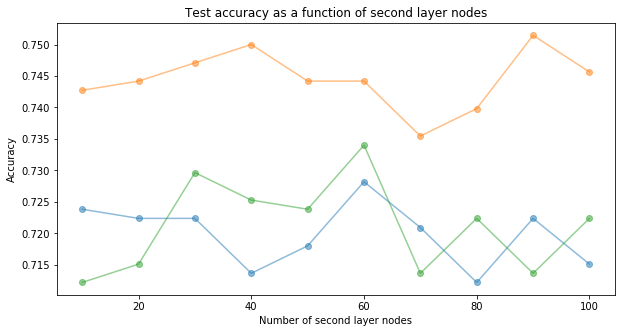

In [152]:
fig = plt.figure(figsize = (10, 5))
for accs in cat:
    plt.plot(nodes, accs, '-o', alpha = 0.5)
plt.xlabel("Number of second layer nodes")
plt.ylabel("Accuracy")
plt.title("Test accuracy as a function of second layer nodes")
plt.show()

Again, the accuracy of the model seems to decrease as we increase its complexity, which implies overfitting. Let's combine our results so far and create a low-complexity model with a dropout layer.

In [153]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, test_size = 0.2, shuffle = True)
cv_accs = []
cv_losses = []
kf = KFold(n_splits = 10)
preds = []
for train_index, cv_index in kf.split(X_train_):
    X_train, X_cv, y_train, y_cv = X_train_[train_index], X_train_[cv_index], y_train_[train_index], y_train_[cv_index]
    model = keras.Sequential([keras.layers.Dense(20, input_dim = 151, activation = "relu"),
                          keras.layers.Dropout(0.1),
                          keras.layers.Dense(10, activation = "relu"),
                          keras.layers.Dense(1, activation = "sigmoid")])
    model.compile(optimizer = "adam",
                  loss = keras.losses.BinaryCrossentropy(),
                  metrics = ['accuracy'])
    model.fit(X_train, y_train, epochs = 15, verbose = 0)
    cv_loss, cv_acc = model.evaluate(X_cv,  y_cv, verbose = 0)
    cv_losses.append(cv_loss)
    cv_accs.append(cv_acc)
    pred = model.predict(X_test_)
    preds.append(pred)
y_pred = np.rint(np.mean(preds, axis = 0).flatten()).astype(int)
score = accuracy_score(y_test_, y_pred)
print("test accuracy: ", score)
print("cross-validation accuracy: ", np.mean(cv_accs))
print("cross-validation loss: ", np.mean(cv_losses))

test accuracy:  0.7252906976744186
cross-validation accuracy:  0.7208813
cross-validation loss:  0.5577540690769955


A more systematic way to choose the architecture of the neural network is to create a surface plot of accuracy as a function of layer nodes. One axis tracks the number of first layer nodes, while the second tracks the number of second layer nodes (we can add more axes for more layers, but it becomes more difficult to visualize). Let's attempt this approach. Since we have to train a quadratic number of models, we'll keep the node range fairly small.

In [154]:
x1, x2 = np.meshgrid(np.linspace(10, 20, 11), np.linspace(10, 20, 11), indexing = 'ij')
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, test_size = 0.2, shuffle = True)
kf = KFold(n_splits = 10)
z = []
for i in range(11):
    for j in range(11):
        preds = []
        for train_index, cv_index in kf.split(X_train_):
            X_train, X_cv, y_train, y_cv = X_train_[train_index], X_train_[cv_index], y_train_[train_index], y_train_[cv_index]
            model = keras.Sequential([keras.layers.Dense(x1[i, j], input_dim = 151, activation = "relu"),
                                  keras.layers.Dropout(0.1),
                                  keras.layers.Dense(x2[i, j], activation = "relu"),
                                  keras.layers.Dense(1, activation = "sigmoid")])
            model.compile(optimizer = "adam",
                          loss = keras.losses.BinaryCrossentropy(),
                          metrics = ['accuracy'])
            model.fit(X_train, y_train, epochs = 15, verbose = 0)
            pred = model.predict(X_test_)
            preds.append(pred)
        y_pred = np.rint(np.mean(preds, axis = 0).flatten()).astype(int)
        z.append(accuracy_score(y_test_, y_pred))

Let's plot the results.

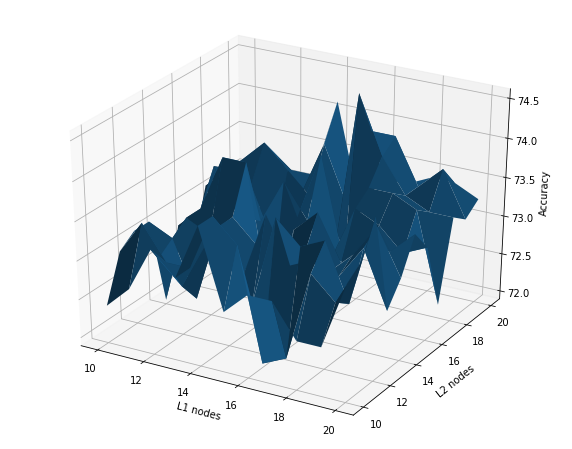

In [168]:
fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111, projection = '3d')
ax.plot_surface(x1, x2, (np.array(z) * 100).reshape(x1.shape))
ax.set_xlabel("L1 nodes")
ax.set_ylabel("L2 nodes")
ax.set_zlabel("Accuracy")
plt.show()

The surface plot is very jagged and doesn't tell us much about which architecture to choose. One reason for the lack of continuity is the random initialization of the Keras models. By default, the weights are drawn from a uniform distribution. Ideally they should converge to the same optimal set of values, but due to random initialization this is not guaranteed. Different initalizations could converge to different solutions, or fail to converge at all with insufficient training times.